<a href="https://colab.research.google.com/github/adeepH/SPDRA_2021_SharedTask/blob/main/spdra_scibert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install transformers


     |████████████████████████████████| 1.5MB 8.7MB/s 
     |████████████████████████████████| 890kB 29.3MB/s 
     |████████████████████████████████| 2.9MB 43.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=a46fccd040af3a136c8532cc58d04b1beba7b3cd4c5e9adaa2578cc4bc2e7f11
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/sdpra2021/train.csv',delimiter=',',
                 header=None,names=['text','label'])

train.label = train.label.apply({'CL':0,'CR':1,'DC':2,
'DS':3,'LO':4, 'NI':5, 'SE':6}.get)
val = pd.read_csv('/content/drive/MyDrive/sdpra2021/validation.csv',delimiter=',',
                 header=None,names=['text','label'])

val.label = val.label.apply({'CL':0,'CR':1,'DC':2,
'DS':3,'LO':4, 'NI':5, 'SE':6}.get)

test = pd.read_csv('/content/drive/MyDrive/sdpra2021/test.csv',delimiter=',',
                 header=None,names=['text'])

In [7]:

print('Training set size:',train.shape)
print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (16800, 2)
Testing set size: (7000, 1)
validation set size: (11200, 2)


In [8]:
max(train.text.apply(len))

3276

In [9]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [10]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.label.values),
                                                  train.label.values)
class_weights

array([0.87591241, 0.90225564, 1.17531832, 0.87687249, 1.32523468,
       0.8683068 , 1.17302053])

In [11]:
def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.text.to_numpy(),
      label = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [12]:
from transformers import *
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'allenai/scibert_scivocab_uncased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)


In [13]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

In [14]:
bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

In [15]:
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes,pre_trained):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained(pre_trained,return_dict=False)
    self.drop = nn.Dropout(p=0.5)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.auto.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.5)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _,pooled_output = self.auto(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return self.out(output)

In [16]:
import torch.nn as nn
from transformers import BertModel,BertTokenizer
class MixedBertModel(nn.Module):
    def __init__(self,pre_trained='allenai/scibert_scivocab_uncased'):
        super().__init__()
        
        self.bert = BertModel.from_pretrained(pre_trained)
        self.hidden_size = self.bert.config.hidden_size
        self.LSTM = nn.LSTM(self.hidden_size,self.hidden_size,bidirectional=True)
        self.clf = nn.Linear(self.hidden_size*2,1)
        
    def forward(self,inputs):
        
        encoded_layers, pooled_output = self.bert(input_ids=inputs[0],attention_mask=inputs[1])
        encoded_layers = encoded_layers.permute(1, 0, 2)
        enc_hiddens, (last_hidden, last_cell) = self.LSTM(pack_padded_sequence(encoded_layers, inputs[2]))
        output_hidden = torch.cat((last_hidden[0], last_hidden[1]), dim=1)
        output_hidden = F.dropout(output_hidden,0.2)
        output = self.clf(output_hidden)
        
        return F.softmax(output)

In [17]:
model = RFClassifier(7,'allenai/scibert_scivocab_uncased')
#model = MixedBertModel()
model = model.to(device)

In [18]:

EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [19]:

def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [20]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [21]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    best_accuracy = val_acc
torch.save(model.state_dict(),'scibert.bin')

Epoch: 01 | Epoch Time: 7m 56s
Train Loss 0.5094333556294441 accuracy 0.8626190476190476
Val Loss 0.29357400652553356 accuracy 0.9140178571428571

Epoch: 02 | Epoch Time: 8m 27s
Train Loss 0.239958913510754 accuracy 0.9376785714285715
Val Loss 0.3050367723165878 accuracy 0.9172321428571428

Epoch: 03 | Epoch Time: 8m 28s
Train Loss 0.157979330762866 accuracy 0.9632738095238095
Val Loss 0.335039132929274 accuracy 0.9160714285714285

Epoch: 04 | Epoch Time: 8m 27s
Train Loss 0.09850543167708176 accuracy 0.980297619047619
Val Loss 0.36746010057561634 accuracy 0.9180357142857143

Epoch: 05 | Epoch Time: 8m 27s
Train Loss 0.06895697188164507 accuracy 0.9874404761904761
Val Loss 0.38653571152726984 accuracy 0.9174107142857143



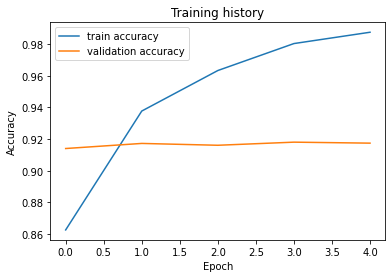

In [23]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

In [24]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

0.9174107142857143

In [25]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [26]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

In [27]:
class_name = ['CL' ,'CR' ,'DC' ,
'DS' ,'LO' , 'NI' , 'SE' ]

In [28]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0))

              precision    recall  f1-score   support

          CL       0.98      0.98      0.98      1866
          CR       0.92      0.91      0.91      1835
          DC       0.82      0.83      0.83      1355
          DS       0.93      0.93      0.93      1774
          LO       0.93      0.93      0.93      1217
          NI       0.91      0.91      0.91      1826
          SE       0.89      0.91      0.90      1327

    accuracy                           0.92     11200
   macro avg       0.91      0.91      0.91     11200
weighted avg       0.92      0.92      0.92     11200



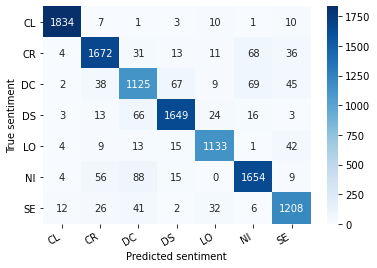

In [29]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

In [ ]:
from google.colab import files
files.download('scibert.bin')

In [31]:
spdra_scibert_preds = pd.DataFrame(list(zip(y_review_texts,y_test.tolist(),y_pred.tolist())),
                          columns = ['text','true_labels','pred_labels'])
spdra_scibert_preds.head(4)
spdra_scibert_preds.to_csv('spdra_scibert_preds.csv')

# ***Inference***

In [35]:
Model = RFClassifier(7,'allenai/scibert_scivocab_uncased')
Model.load_state_dict(torch.load('scibert.bin'))
Model.to(device)
for param in model.parameters():
    param.requires_grad = False
Model.eval()

RFClassifier(
  (auto): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [36]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  Model,
  val_data_loader
)

In [37]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0))

              precision    recall  f1-score   support

          CL       0.98      0.98      0.98      1866
          CR       0.92      0.91      0.91      1835
          DC       0.82      0.83      0.83      1355
          DS       0.93      0.93      0.93      1774
          LO       0.93      0.93      0.93      1217
          NI       0.91      0.91      0.91      1826
          SE       0.89      0.91      0.90      1327

    accuracy                           0.92     11200
   macro avg       0.91      0.91      0.91     11200
weighted avg       0.92      0.92      0.92     11200

